---------------------------
# Do the urbanized countries tend to have highest GDP per capita?
---------------------------

<div style="text-align: right"> Author: DESWYSEN B.</div>

---------------------------
## <span style="color:red">__Table of content:__</span>



__I. Objectiv and context__

__II. Setup Jupyter env and import libs__

__III. Data import and loading__

    1. World bank (Kaggle) dataset
        - Indicators
        - Countries classifications
    2. World bank "income group" categories
    3. Geographical data (natural earth)
        - Admin boundaries
        - Graticules

__IV. World bank countries classification__

    1. Geograhic regions classification
    2. Income group classification

__V. Indicators analysis__

    1. GDP per capita
    2. Urban population (% of total)
    3. Urban population VS GDP per capita






---------------------------
## <span style="color:red">__I. Objectiv and context__</span>
---------------------------
According to the literature in the field, the relationship between the level of urbanization of a region and its level of development is not clearly established.

> "Recent economic analyzes shed some light on the often inconclusive general relationships between urbanization and economic development. In general, studies show that the evolution of urbanization can only be meaningfully understood by situating it in relation to the mechanisms of economic growth and the spatial dynamics associated with the different stages of development."

> Translated from the french: A Catin Maurice, Van Huffel Christophe, « Urbanisation, étapes de développement et ouverture internationale », Mondes en développement, 2008/3 (n° 143), p. 69-78. DOI : 10.3917/med.143.0069. URL : https://www.cairn-int.info/revue-mondes-en-developpement-2008-3-page-69.htm 


As a basic approach of this problematic, I will compare countries urbanization rate (urban population % of total) and their GDP per capita value (current US $).

To achieve this goal I will use the "World development indicators" dataset provided by the World Bank on kaggle ( https://www.kaggle.com/worldbank/world-development-indicators ) and some extra dataset like the income group classification from the World Bank and the world boundaries from Natural Earth.

-------------------
## <span style="color:red">__II. Setup Jupyter environment and import libs__</span>
-------------------

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy import stats

-----------------
## <span style="color:red">__III. Data import and loading__</span>
-----------------


### <span style="color:orange">II.1. World bank (Kaggle) dataset</span>
Source: https://www.kaggle.com/worldbank/world-development-indicators

Indicators data are ine the Indicator.csv file.

 #### Indicators


In [3]:
df_indicators = pd.read_csv('./data/Indicators.csv')

print('Dimensions of the dataset: ' )
df_indicators.shape

Dimensions of the dataset: 


(5656458, 6)

#### Countries classifications
Data are provided in the same kaggle world bank dataset than the indicator. The concerned fils is 'Country.csv'

Source: https://www.kaggle.com/worldbank/world-development-indicators

In [4]:
df_countries_wb_classif = pd.read_csv('./data/Country.csv')

print('Dimensions of the dataset: ' )
df_countries_wb_classif.shape

Dimensions of the dataset: 


(247, 31)

### <span style="color:orange">II.2. World bank "income group" categories</span>

To get the data corresponding to the time period we are focusing on, we will not use data provided on kaggle in the 'Country.csv' file but we will download a spreadsheet containing historical income groups of the countries. In this way, if a country has changed group over time, our analysis will not be distorted.

Source: https://databank.worldbank.org/data/download/site-content/OGHIST.xls

In [5]:
!wget -O data/OGHIST.xls https://databank.worldbank.org/data/download/site-content/OGHIST.xls -P data

--2020-11-27 13:28:04--  https://databank.worldbank.org/data/download/site-content/OGHIST.xls
Resolving databank.worldbank.org (databank.worldbank.org)... 192.86.98.102
Connecting to databank.worldbank.org (databank.worldbank.org)|192.86.98.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 302080 (295K) [application/vnd.ms-excel]
Saving to: ‘data/OGHIST.xls’

OGHIST.xls          100%[===================>] 295.00K   505KB/s    in 0.6s    

2020-11-27 13:28:05 (505 KB/s) - ‘data/OGHIST.xls’ saved [302080/302080]



### <span style="color:orange">II.3. Geographical data (natural earth)</span>

#### Admin boundaries
Source: http://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/

In [6]:
!wget -O data/ne_110m_admin_0_countries.zip https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip -P data

--2020-11-27 13:28:06--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 66.147.242.194
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|66.147.242.194|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip [following]
--2020-11-27 13:28:07--  https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
Resolving naciscdn.org (naciscdn.org)... 146.201.97.163
Connecting to naciscdn.org (naciscdn.org)|146.201.97.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196764 (192K) [application/zip]
Saving to: ‘data/ne_110m_admin_0_countries.zip’

ne_110m_admin_0_cou 100%[===================>] 192.15K   463KB/s    in 0.4s    

2020-11-27 13:28:08 (463 KB/s) - ‘data/ne_110m_admin_0_countries

In [7]:
# get the countries geometries from a zipped shapefile. Coordinate system is latitude-longitude (EPSG code:4326)
gdf_countries = gpd.read_file("zip://./data/ne_110m_admin_0_countries.zip")

In [8]:
# Reproject these data in Mollweide coordinate system to conserv areas when plotting
gdf_countries_mollweide = gdf_countries.copy()
gdf_countries_mollweide = gdf_countries.to_crs("ESRI:54009")

#### Graticules
> Graticules = grid of longitudinal and latitudinal lines, on which maps are drawn.

Source: https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-graticules/


In [9]:
!wget -O data/ne_10m_graticules_5.zip https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_graticules_5.zip -P data

--2020-11-27 13:28:09--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_graticules_5.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 66.147.242.194
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|66.147.242.194|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://naciscdn.org/naturalearth/10m/physical/ne_10m_graticules_5.zip [following]
--2020-11-27 13:28:11--  https://naciscdn.org/naturalearth/10m/physical/ne_10m_graticules_5.zip
Resolving naciscdn.org (naciscdn.org)... 146.201.97.163
Connecting to naciscdn.org (naciscdn.org)|146.201.97.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216118 (211K) [application/zip]
Saving to: ‘data/ne_10m_graticules_5.zip’

ne_10m_graticules_5 100%[===================>] 211.05K   411KB/s    in 0.5s    

2020-11-27 13:28:12 (411 KB/s) - ‘data/ne_10m_graticules_5.zip’ saved [216118/216118]



In [10]:
# get the graticules geometries from a zipped shapefile. Coordinate system is latitude-longitude (EPSG code:4326)
gdf_graticules = gpd.read_file("zip://./data/ne_10m_graticules_5.zip")

In [11]:
# Reproject in Mollweide coordinate system, like countries
gdf_graticules_mollweide = gdf_graticules.copy()
gdf_graticules_mollweide = gdf_graticules.to_crs("ESRI:54009")

---------------
## <span style="color:red">__IV. Individual indicators analysis__</span>
---------------



A first analysis will focus on one indicator at a time, to understand how they are distributed.

First of all, we extract the data in 2 dataframe:

In [12]:
# extract the concerned indicator from the raw dataset
indicator_gdp='NY.GDP.PCAP.CD'
df_gdp_per_cap = df_indicators[df_indicators.IndicatorCode==indicator_gdp]

print('Dimensions of the dataset: ' )
df_gdp_per_cap.shape

Dimensions of the dataset: 


(10343, 6)

In [13]:
# extract the concerned indicator from the raw dataset
indicator_urb='SP.URB.TOTL.IN.ZS'
df_urb_pop = df_indicators[df_indicators.IndicatorCode==indicator_urb]

print('Dimensions of the dataset: ' )
df_urb_pop.shape

Dimensions of the dataset: 


(13415, 6)

### <span style="color:orange">IV.0. Filter the dataset to get only countries</span>

If we look at the 'CountryName' colum, we can see that we have rows corresponding to groups of countries.
For this step, we need to exclude them because we will focus on individual country values for our indicators. We will aggregate them by groups after.

To realize this filter, we will use the 'Country.csv' file, containing the list of countries.

Let's try to identify these groups of countries:

In [14]:
# create a filter using the 'SpecialNote' column: 
# this column contains 'aggregate' for groups of countries
filter_contains= df_countries_wb_classif['SpecialNotes'].str.contains('aggregate',na=False)

print('List of the groups of countries: ')
df_countries_aggr = df_countries_wb_classif[filter_contains]
df_countries_aggr.LongName.tolist()

List of the groups of countries: 


['Arab World',
 'Caribbean small states',
 'Central Europe and the Baltics',
 'East Asia & Pacific (all income levels)',
 'East Asia & Pacific (developing only)',
 'Euro area',
 'Europe & Central Asia (all income levels)',
 'Europe & Central Asia (developing only)',
 'European Union',
 'Fragile situations',
 'Heavily indebted poor countries (HIPC)',
 'High income',
 'High income: nonOECD',
 'High income: OECD',
 'Latin America & Caribbean (all income levels)',
 'Latin America & Caribbean (developing only)',
 'Least developed countries: UN classification',
 'Low & middle income',
 'Low income',
 'Lower middle income',
 'Middle East & North Africa (all income levels)',
 'Middle East & North Africa (developing only)',
 'Middle income',
 'North America',
 'OECD members',
 'Other small states',
 'Pacific island small states',
 'Small states',
 'South Asia',
 'Sub-Saharan Africa (all income levels)',
 'Sub-Saharan Africa (developing only)',
 'Upper middle income',
 'World']

We can now exclude them by using the opposite (~) of the previous filter:

In [15]:
# filter and keep countries not in (using ~) the identified aggregates
df_countries_not_in_aggr = df_countries_wb_classif[~filter_contains]

# GDP per capita dataframe:
print('Dimensions of the dataset: ' )
df_countries_not_in_aggr.shape

Dimensions of the dataset: 


(214, 31)

Then, we can make a join:

In [16]:
# GDP per cap indicator
df_countries_gdp_per_cap = df_gdp_per_cap.merge(
    df_countries_not_in_aggr['CountryCode'],
    left_on='CountryCode',
    right_on='CountryCode',
    how='inner'
)

print('Dimensions of the dataset for GDP per cap. analysis: ' + str(df_countries_gdp_per_cap.shape) )

# Urbanize pop indicator:
df_countries_urb_pop = df_urb_pop.merge(
    df_countries_not_in_aggr['CountryCode'],
    left_on='CountryCode',
    right_on='CountryCode',
    how='inner'
)

print('Dimensions of the dataset for urbanization analysis: ' + str (df_countries_urb_pop.shape) )

Dimensions of the dataset for GDP per cap. analysis: (8752, 6)
Dimensions of the dataset for urbanization analysis: (11600, 6)


### <span style="color:orange">IV.1. Choice of a reference year</span>

We check the presence of those indicators in the dataset over time by counting the number of values (=countries) per year:

1. GDP per capita indicator:

In [17]:
# group by Year to heck the values available per year in the dataset
df_gdp_per_cap_count = df_countries_gdp_per_cap.groupby(['Year'])['CountryCode'].count()

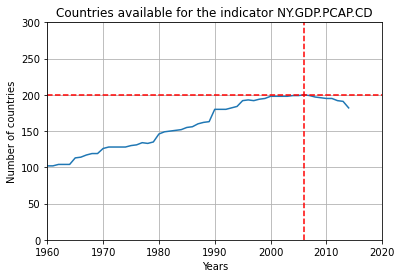

Maximum is in 2006 with a count of 200 countries.


In [18]:
# Considering GDP indicator
# compute max to get the year containing the maximum of data for this indicator
xmax_gdp=df_gdp_per_cap_count.idxmax()
ymax_gdp=df_gdp_per_cap_count.max()

# plot it in a line chart
ax=plt.subplots()

plt.plot(df_gdp_per_cap_count.index, 
         df_gdp_per_cap_count.values, 
         label='Countries available for the indicator'+ indicator_gdp)

plt.xlabel('Years') 
plt.ylabel('Number of countries') 

plt.title('Countries available for the indicator ' + indicator_gdp ) 

plt.axis([1960, 2020,0,300])

plt.axhline(y=ymax_gdp,xmin=0,xmax=xmax_gdp, color="red", linestyle="--")
plt.axvline(x=xmax_gdp,ymin=0,ymax=ymax_gdp, color="red", linestyle="--")

plt.grid(True)
plt.show()

print('Maximum is in ' +str(xmax_gdp)+' with a count of ' + str(ymax_gdp) +' countries.')

2. Urbanization indicator:

In [19]:
# check the values available per year in the dataset
df_urb_pop_count = df_countries_urb_pop.groupby(['Year'])['CountryCode'].count()

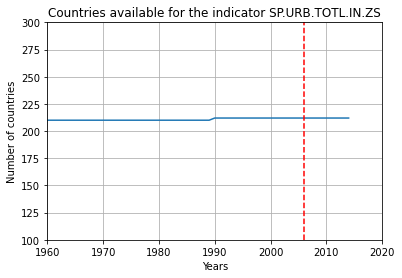

Maximum is in 1990 with a count of 212 countries.


In [20]:
# compute max to get the year containing the maximum of data for this indicator
xmax_urb=df_urb_pop_count.idxmax()
ymax_urb=df_urb_pop_count.max()

# plot it in a line chart
ax=plt.subplots()

plt.plot(df_urb_pop_count.index, 
         df_urb_pop_count.values, 
         label='Countries available for the indicator '+str(indicator_urb))

plt.xlabel('Years') 
plt.ylabel('Number of countries') 

plt.title('Countries available for the indicator '+str(indicator_urb))
         
plt.axis([1960, 2020,100,300])

# plot the year we obtained previously
plt.axvline(x=xmax_gdp,ymin=0,ymax=ymax_urb, color="red", linestyle="--")

plt.grid(True)
plt.show()

print('Maximum is in ' +str(xmax_urb)+' with a count of ' + str(ymax_urb) +' countries.')

The number seems to be constant after 1990. 
We can check if the previous maximum correspond to a max for the second indicator too:

In [21]:
# check if year 2006 is equal to max of count
print('The year '+str(xmax_gdp)+' contains a max of data for the secund indicator ('+str(indicator_urb)+') too: ') 
df_urb_pop_count[df_urb_pop_count.index==xmax_gdp].values[0] == ymax_urb

The year 2006 contains a max of data for the secund indicator (SP.URB.TOTL.IN.ZS) too: 


True

<span style="color:red">__We will use the year 2006 for our analysis, it contains a maximum of available values for our 2 indicators.__</span>


### <span style="color:orange">IV.2. GDP per capita</span>

| IndicatorCode    	| IndicatorName                  	|
|------------------	|--------------------------------	|
| 'NY.GDP.PCAP.CD' 	| 'GDP per capita (current US$)' 	|

We will focus on this indicator which is based on the following ratio per year for each country:

<center>
$GDP_{per \  capita} = \frac{GDP_{current \  US \  \$}}{Population} $
</center>


So we can identify the best year, with the most of data available for this indicator, in the dataset:

In [22]:
# Extract the choosen year 
df_gdp_per_cap_ref_year = df_countries_gdp_per_cap[df_countries_gdp_per_cap['Year']==xmax_gdp]

print('Dimensions of the dataset: ' )
df_gdp_per_cap_ref_year.shape

Dimensions of the dataset: 


(200, 6)

To have a "naiv" overview of the distribution for this indicator, we can use an histogram on the raw data to get the frequecy distribution:

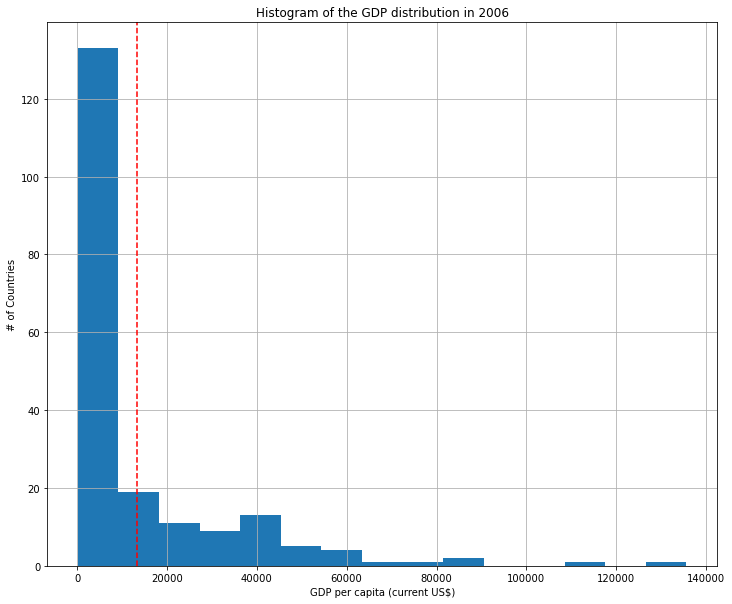

Size: 200
Minimum: 154.924525713107
Maximum: 135629.605720617
Range of value is: 135474.68119490388

  1: 154.92 --> 9186.57
  2: 9186.57 --> 18218.22
  3: 18218.22 --> 27249.86
  4: 27249.86 --> 36281.51
  5: 36281.51 --> 45313.15
  6: 45313.15 --> 54344.8
  7: 54344.8 --> 63376.44
  8: 63376.44 --> 72408.09
  9: 72408.09 --> 81439.73
  10: 81439.73 --> 90471.38
  11: 90471.38 --> 99503.02
  12: 99503.02 --> 108534.67
  13: 108534.67 --> 117566.31
  14: 117566.31 --> 126597.96
  15: 126597.96 --> 135629.61


In [60]:
# extract the mean to plot on the histogram
xmean_gdp=df_gdp_per_cap_ref_year.Value.values.mean()
bins=15

fig, ax = plt.subplots(figsize=(12,10))
plt.hist(df_gdp_per_cap_ref_year.Value.values, bins, density=False)

plt.xlabel(df_gdp_per_cap_ref_year['IndicatorName'].iloc[0])
plt.ylabel('# of Countries')
plt.title('Histogram of the GDP distribution in 2006')

plt.grid(True)

plt.axvline(x=xmean_gdp, color="red", linestyle="--")


plt.savefig('figures/GDP_per_capita_hist_2006.png')

plt.show()

# Print distribution parameters
# compute max and min in thise frequencies
xmax_count_gdp=df_gdp_per_cap_ref_year.Value.values.max()
xmin_count_gdp=df_gdp_per_cap_ref_year.Value.values.min()
x_count_gdp = df_gdp_per_cap_ref_year.Value.count()

# compute the range
range_gdp =xmax_count_gdp-xmin_count_gdp

# display some caract. from this distribution
print('Size: '+ str(x_count_gdp))
print('Minimum: '+ str(xmin_count_gdp))
print('Maximum: '+ str(xmax_count_gdp))
print('Range of value is: '+ str(xmax_count_gdp-xmin_count_gdp))
print()

bin_size=range_gdp/bins

lower_limit= xmin_count_gdp
upper_limit= xmin_count_gdp+bin_size

# Display bins lower/upper limit from the frequencies
for i in range(bins):
    print('  '+ str(i+1) + ': ' + str(round(lower_limit,2)) +' --> ' + str(round(upper_limit,2)))
    lower_limit=lower_limit+bin_size
    upper_limit=upper_limit+bin_size
  

We can observ that the distribution is very asymetric: most of the frequencies lie on the left side of the histogram, the mode is left compared to the mean and the peak we have is observed in our lower GDP "bin". It means that most of the countries have a GDP per capita (US$) between 154.92 and 9186.57.

In [24]:
# Compute part of the pop in the 1st bin
nb_in_bin1 = df_gdp_per_cap_ref_year[df_gdp_per_cap_ref_year['Value'] < 9186.57].Value.count()

print('Part of the population in the 1st bin: ' + str(round(100* nb_in_bin1/x_count_gdp,2) ) +'%' )

Part of the population in the 1st bin: 66.5%


This indicate us that some rows have very high GDP per capita, let's have a look at raws in the 3rd bin or higher:

In [25]:
df_gdp_per_cap_ref_year[df_gdp_per_cap_ref_year['Value'] > 27249.86].head(10)

CountryName CountryCode                 IndicatorName  \
137              Australia         AUS  GDP per capita (current US$)   
192                Austria         AUT  GDP per capita (current US$)   
357                Belgium         BEL  GDP per capita (current US$)   
522                Bermuda         BMU  GDP per capita (current US$)   
943                 Canada         CAN  GDP per capita (current US$)   
1493               Denmark         DNK  GDP per capita (current US$)   
1713               Finland         FIN  GDP per capita (current US$)   
1768                France         FRA  GDP per capita (current US$)   
2153  Hong Kong SAR, China         HKG  GDP per capita (current US$)   
2208               Iceland         ISL  GDP per capita (current US$)   

       IndicatorCode  Year         Value  
137   NY.GDP.PCAP.CD  2006  36084.858978  
192   NY.GDP.PCAP.CD  2006  40430.993614  
357   NY.GDP.PCAP.CD  2006  38852.361034  
522   NY.GDP.PCAP.CD  2006  83912.697798  
943   NY.GDP.PCAP.CD  2006  40243.552284  
1493  NY.GDP.PCAP.CD  2006  52041.002973  
1713  NY.GDP.PCAP.CD  2006  41120.676506  
1768  NY.GDP.PCAP.CD  2006  36544.508534  
2153  NY.GDP.PCAP.CD  2006  28224.215061  
2208  NY.GDP.PCAP.CD  2006  56097.115089

To have a global overview, we will plot it on a world map. But first we need to manipulate ("normalize") the distribution so that it approaches a normal distribution:

- Histogram after applying $x^{0.01}$ :

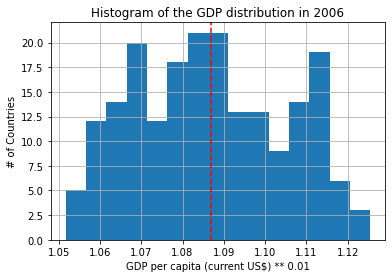

In [26]:
# Apply ** 0.01 on gdp_per_capita 

new_col='Value_exp_0_01'

# apply ** 0.01 transform
df_gdp_per_cap_ref_year_norm = df_gdp_per_cap_ref_year.copy()
df_gdp_per_cap_ref_year_norm[new_col] = df_gdp_per_cap_ref_year_norm['Value'] ** 0.01

plt.hist(df_gdp_per_cap_ref_year_norm.Value_exp_0_01.values, 15, density=False)

plt.xlabel(df_gdp_per_cap_ref_year_norm['IndicatorName'].iloc[0] +  ' ** 0.01')
plt.ylabel('# of Countries')
plt.title('Histogram of the GDP distribution in 2006')

plt.grid(True)

xmean=df_gdp_per_cap_ref_year_norm.Value_exp_0_01.values.mean()
plt.axvline(x=xmean, color="red", linestyle="--")

plt.show()

The distribution seems to be more spreaded out after the $x^{0.01}$ transformation.

- Histogram after applying $log_{10}$ :

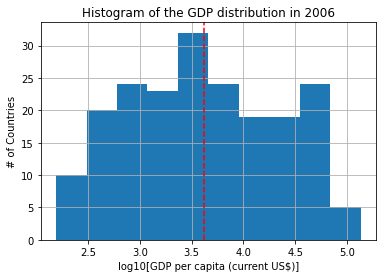

In [27]:

df_gdp_per_cap_ref_year_norm['Value_log10'] = np.log10(df_gdp_per_cap_ref_year_norm['Value'])

plt.hist(df_gdp_per_cap_ref_year_norm.Value_log10.values, 10, density=False)

ax.set_xscale('log')

plt.xlabel( 'log10['+ df_gdp_per_cap_ref_year_norm['IndicatorName'].iloc[0] +']')
plt.ylabel('# of Countries')
plt.title('Histogram of the GDP distribution in 2006')

plt.grid(True)

xmean=df_gdp_per_cap_ref_year_norm.Value_log10.values.mean()
plt.axvline(x=xmean, color="red", linestyle="--")


plt.show()

The distribution seems to be more spreaded out after the $log_{10}$  transformation and the shape is more like a bell, we approach a normal distribution


We can now use choropleth map tools (like in these examples: https://gisgeography.com/choropleth-maps-data-classification/ ) to have a worldwide overview (on a map):

- First of all, we create the geodataframe combining countries boundaries and the data we are working on:

In [28]:
# create a geodataframe by joining on the ISO A3 identifier
gdf_gdp_per_cap = gdf_countries_mollweide[['WB_A3', 'geometry']].merge(
    df_gdp_per_cap_ref_year_norm, 
    left_on='WB_A3', 
    right_on='CountryCode', 
    how='left',
    indicator=True)
gdf_gdp_per_cap.shape
print('Size of the dataset: '+ str(gdf_gdp_per_cap.shape))

Size of the dataset: (177, 11)


<span style="color:red">__Important note:__</span>

__The geodataframe has less rows than the indicator dataframe because some country codes are not matching during the join. The missing countries are:__

In [29]:
# use the indicator parameter to get, for each row, the place in both of the dataframe.
# It can be 'left_only', 'right_only' or 'both'
missing_countries=gdf_countries_mollweide[['WB_A3', 'geometry']].merge(
    df_gdp_per_cap_ref_year_norm, 
    left_on='WB_A3', 
    right_on='CountryCode', 
    how='outer',
    indicator=True).query('_merge == "right_only"')

missing_countries_list= missing_countries['CountryName'].values.tolist()
missing_countries_list

['Bermuda',
 'Hong Kong SAR, China',
 'Norway',
 'Seychelles',
 'Singapore',
 'St. Kitts and Nevis',
 'St. Vincent and the Grenadines',
 'Andorra',
 'Kiribati',
 'Liechtenstein',
 'Malta',
 'Monaco',
 'Tonga',
 'Mauritius',
 'Antigua and Barbuda',
 'Dominica',
 'Grenada',
 'St. Lucia',
 'Bahrain',
 'Barbados',
 'Cabo Verde',
 'Comoros',
 'Maldives',
 'Marshall Islands',
 'Macao SAR, China',
 'Samoa',
 'Micronesia, Fed. Sts.',
 'Palau',
 'Tuvalu',
 'Aruba',
 'Isle of Man',
 'Cayman Islands',
 'Channel Islands',
 'Faeroe Islands',
 'San Marino',
 'Sao Tome and Principe']

They are mainly small Islands or countries which evolved between the date of our geometries (2020) and the date of our indicators (2006).

- If we plot raw 'Value' for this indicator on a map using a 'equal_interval' classification on 7 classes (= number max of classes that the eye can naturally distinguish) we are in the same case than a division in 7 bins in an  histogram.



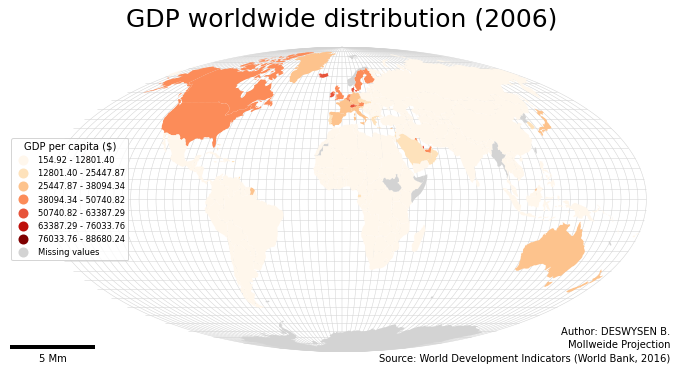

In [30]:
# create a map figure
fig, ax = plt.subplots(figsize=(12,10))

ax.axis('off')

gdf_gdp_per_cap.plot(column='Value', 
             ax=ax, 
             cmap='OrRd', 
             missing_kwds={'color': 'lightgrey',
                          'label': 'Missing values'},
             # scheme option can be set to any scheme provided by mapclassify (e.g. ‘box_plot’, ‘equal_interval’, ‘fisher_jenks’, ‘fisher_jenks_sampled’, ‘headtail_breaks’, ‘jenks_caspall’, ‘jenks_caspall_forced’, ‘jenks_caspall_sampled’, ‘max_p_classifier’, ‘maximum_breaks’, ‘natural_breaks’, ‘quantiles’, ‘percentiles’, ‘std_mean’ or ‘user_defined’
             scheme='equal_interval',
             k=7,
             legend=True,
             legend_kwds={'loc': 'center left',
                          #'loc': 'lower left',
                          'fontsize':'small',
                          'title':'GDP per capita ($)'
                         },
             zorder=2
            )

# add graticules to have lat/lon overview
gdf_graticules_mollweide.plot(
        ax=ax, 
        color="lightgray", 
        linewidth=0.5, 
        zorder=1)

ax.set_title('GDP worldwide distribution (2006)', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})

ax.text(0.99, 0.01, 'Source: World Development Indicators (World Bank, 2016)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.05, 'Mollweide Projection',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.09, 'Author: DESWYSEN B.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

scalebar = ScaleBar(dx=1,units='m',dimension='si-length',location='lower left')

plt.gca().add_artist(scalebar)



Once it is ploted, we don't have a significant visual differentiation, due to the shape of our distribution.


If we try with the log10 of the indicator, we have:

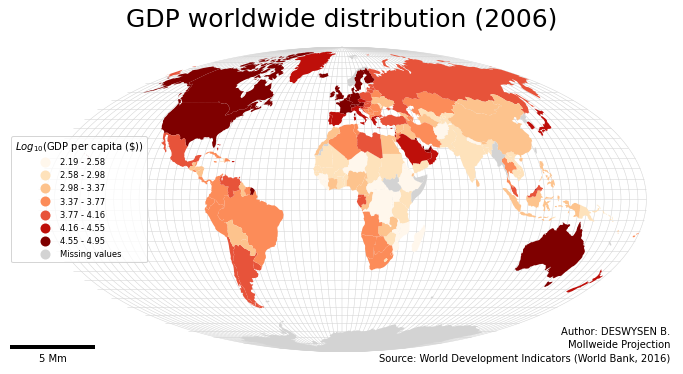

In [31]:
# create a map figure
fig, ax = plt.subplots(figsize=(12,10))

ax.axis('off')

gdf_gdp_per_cap.plot(column='Value_log10', 
             ax=ax, 
             cmap='OrRd', 
             missing_kwds={'color': 'lightgrey',
                          'label': 'Missing values'},
             # scheme option can be set to any scheme provided by mapclassify (e.g. ‘box_plot’, ‘equal_interval’, ‘fisher_jenks’, ‘fisher_jenks_sampled’, ‘headtail_breaks’, ‘jenks_caspall’, ‘jenks_caspall_forced’, ‘jenks_caspall_sampled’, ‘max_p_classifier’, ‘maximum_breaks’, ‘natural_breaks’, ‘quantiles’, ‘percentiles’, ‘std_mean’ or ‘user_defined’
             scheme='equal_interval',
             k=7,
             legend=True,
             legend_kwds={'loc': 'center left',
                          #'loc': 'lower left',
                          'fontsize':'small',
                          'title':(r'$Log_{10}$(GDP per capita (\$))')
                         },
             zorder=2
            )

# add graticules to have lat/lon overview
gdf_graticules_mollweide.plot(
        ax=ax, 
        color="lightgray", 
        linewidth=0.5, 
        zorder=1)

ax.set_title('GDP worldwide distribution (2006)', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})

ax.text(0.99, 0.01, 'Source: World Development Indicators (World Bank, 2016)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.05, 'Mollweide Projection',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.09, 'Author: DESWYSEN B.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

scalebar = ScaleBar(dx=1,units='m',dimension='si-length',location='lower left')

plt.gca().add_artist(scalebar)

plt.savefig('figures/GDP_per_capita_2006.png')


This result is more convincing! In this case, the classes are better distributed.

### <span style="color:orange">IV.3. Urban population (% of total)</span>


In [32]:
# Extract the year choosen
df_urb_pop_ref_year = df_countries_urb_pop[df_countries_urb_pop['Year']==xmax_urb]

print('Dimensions of the dataset: ' )
df_urb_pop_ref_year.shape

Dimensions of the dataset: 


(212, 6)

If we have a look at the histogram of this indicator:


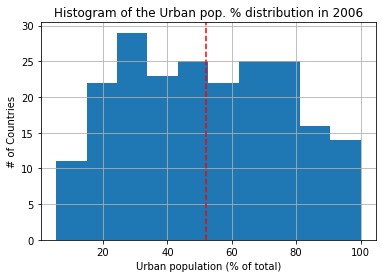

In [61]:
xmean=df_urb_pop_ref_year.Value.values.mean()

plt.hist(df_urb_pop_ref_year.Value.values, 10, density=False)

plt.xlabel(df_urb_pop_ref_year['IndicatorName'].iloc[0])
plt.ylabel('# of Countries')
plt.title('Histogram of the Urban pop. % distribution in 2006')

plt.grid(True)

plt.axvline(x=xmean, color="red", linestyle="--")

plt.savefig('figures/Urban_pop_hist_2006.png')

plt.show()

We can observ that the disribution is centered and doesn't need a transformation. 
It can however be observed that we have a peak corresponding to to weakly urbanized countries (30% of the total population).

If we plot it on a map:

In [34]:
# construct a geodataframe containings indicator and geometries
gdf_urban = gdf_countries_mollweide[['WB_A3', 'geometry']].merge(df_urb_pop_ref_year, left_on='WB_A3', right_on='CountryCode', how='left')

print('Dimensions of the dataset: ' )
gdf_urban.shape

Dimensions of the dataset: 


(177, 8)

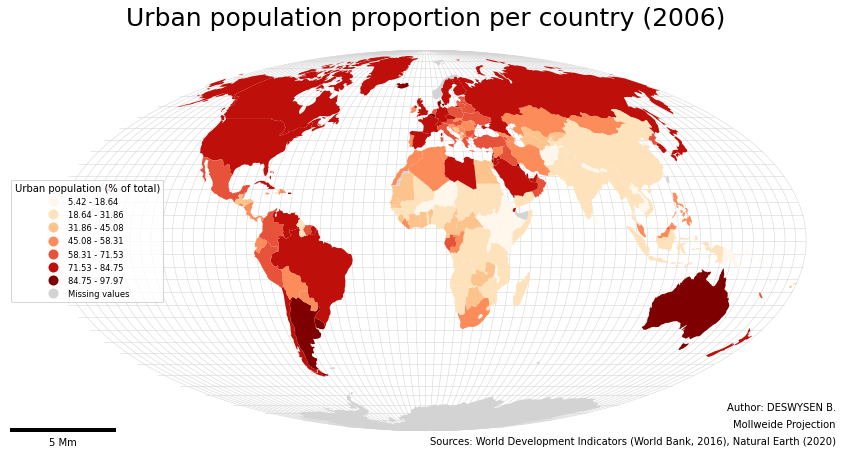

In [35]:
# The scheme option can be set to any scheme provided by mapclassify (e.g. ‘box_plot’, ‘equal_interval’, ‘fisher_jenks’, ‘fisher_jenks_sampled’, ‘headtail_breaks’, ‘jenks_caspall’, ‘jenks_caspall_forced’, ‘jenks_caspall_sampled’, ‘max_p_classifier’, ‘maximum_breaks’, ‘natural_breaks’, ‘quantiles’, ‘percentiles’, ‘std_mean’ or ‘user_defined’

fig, ax = plt.subplots(figsize=(15,12))
divider = make_axes_locatable(ax)

#cax = divider.append_axes("right", size="5%", pad=0.1)

ax.axis('off')

gdf_urban.plot(column='Value', 
             ax=ax, 
             cmap='OrRd', 
             missing_kwds={'color': 'lightgrey',
                          'label': 'Missing values'},
             #scheme='NaturalBreaks',
             #scheme='quantiles',
             scheme='equal_interval',
             k=7,
             legend=True,
             legend_kwds={'loc': 'center left',
                          #'loc': 'lower left',
                          'fontsize':'small',
                          'title':gdf_urban['IndicatorName'].iloc[0]
                         },
             zorder=2,
             #cax=cax
            )

gdf_graticules_mollweide.plot(
        ax=ax, 
        color="lightgray", 
        linewidth=0.5, 
        zorder=1)

ax.set_title('Urban population proportion per country (2006)', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})

ax.text(0.99, 0.01, 'Sources: World Development Indicators (World Bank, 2016), Natural Earth (2020)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.05, 'Mollweide Projection',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.09, 'Author: DESWYSEN B.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

scalebar = ScaleBar(dx=1,units='m',dimension='si-length',location='lower left')

plt.gca().add_artist(scalebar)

plt.savefig('figures/Urban_pop_2006.png')

We can now easlily identify countries where the population is mainly living in cities (Australia, Argentina), or at the opposite mainly living in the country (India, China, Tanzania,...)

-----------------
## <span style="color:red">__V. World bank countries classification__</span>

-----------------

In order to detect patterns by specific group of countries (and not on the full dataset), we will group them according to World Bank classifications.


The world bank provide different countries classifications allowing to group countries using:
> 1. Geographic regions
*Groupings are primarily based on the regions used for administrative purposes by the World Bank. There are two main variants: one which includes all economies, and one which excludes high-income economies (see income groups below for the definition of low-, lower middle-, upper middle-, and high-income categories).*

> 2. Income groups
*Economies are currently divided into four income groupings: low, lower-middle, upper-middle, and high. 
Income is measured using gross national income (GNI) per capita, in U.S. dollars, converted from local currency using the World Bank Atlas method. Estimates of GNI are obtained from economists in World Bank country units; and the size of the population is estimated by World Bank demographers from a variety of sources, including the UN’s biennial World Population Prospects.*

> 3. Operational lending categories
*Economies are divided into IDA, IBRD, and Blend countries based on the operational policies of the World Bank. International Development Association (IDA) countries are those with low per capita incomes that lack the financial ability to borrow from the International Bank for Reconstruction and Development (IBRD). Blend countries are eligible for IDA loans but are also eligible for IBRD loans because they are financially creditworthy.*

Source: https://datahelpdesk.worldbank.org/knowledgebase/articles/378834-how-does-the-world-bank-classify-countries

**In this analysis, we will focus on the 2 first classifications:**
    
    1. Classification based on geographc regions
    2. Classification based on income group



### <span style="color:orange">V.1. Geograhic regions classification</span>
The classification by geographic region is available in the column 'Region' of the data loaded from 'countries.csv'.
To have an overview of this classification, we will plot it on a world map.

In [36]:
# overview of the data coming from countries.csv and loaded in a dataframe
df_countries_wb_classif.head()

CountryCode       ShortName       TableName  \
0         AFG     Afghanistan     Afghanistan   
1         ALB         Albania         Albania   
2         DZA         Algeria         Algeria   
3         ASM  American Samoa  American Samoa   
4         ADO         Andorra         Andorra   

                                  LongName Alpha2Code    CurrencyUnit  \
0             Islamic State of Afghanistan         AF  Afghan afghani   
1                      Republic of Albania         AL    Albanian lek   
2  People's Democratic Republic of Algeria         DZ  Algerian dinar   
3                           American Samoa         AS     U.S. dollar   
4                  Principality of Andorra         AD            Euro   

                                        SpecialNotes  \
0  Fiscal year end: March 20; reporting period fo...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                       Region           IncomeGroup Wb2Code  ...  \
0                  South Asia            Low income      AF  ...   
1       Europe & Central Asia   Upper middle income      AL  ...   
2  Middle East & North Africa   Upper middle income      DZ  ...   
3         East Asia & Pacific   Upper middle income      AS  ...   
4       Europe & Central Asia  High income: nonOECD      AD  ...   

       GovernmentAccountingConcept              ImfDataDisseminationStandard  \
0  Consolidated central government  General Data Dissemination System (GDDS)   
1     Budgetary central government  General Data Dissemination System (GDDS)   
2     Budgetary central government  General Data Dissemination System (GDDS)   
3                              NaN                                       NaN   
4                              NaN                                       NaN   

                              LatestPopulationCensus  \
0                                               1979   
1                                               2011   
2                                               2008   
3                                               2010   
4  2011. Population data compiled from administra...   

                               LatestHouseholdSurvey  \
0  Multiple Indicator Cluster Survey (MICS), 2010/11   
1       Demographic and Health Survey (DHS), 2008/09   
2     Multiple Indicator Cluster Survey (MICS), 2012   
3                                                NaN   
4                                                NaN   

          SourceOfMostRecentIncomeAndExpenditureData  \
0            Integrated household survey (IHS), 2008   
1  Living Standards Measurement Study Survey (LSM...   
2            Integrated household survey (IHS), 1995   
3                                                NaN   
4                                                NaN   

  VitalRegistrationComplete LatestAgriculturalCensus LatestIndustrialData  \
0                       NaN                  2013/14                  NaN   
1                       Yes                     2012               2011.0   
2                       NaN                      NaN               2010.0   
3                       Yes                     2007                  NaN   
4                       Yes                      NaN                  NaN   

  LatestTradeData LatestWaterWithdrawalData  
0          2013.0                    2000.0  
1          2013.0                    2006.0  
2          2013.0                    2001.0  
3             NaN                       NaN  
4          2006.0                       NaN  

[5 rows x 31 columns]

To plot these data on a map, we need to join the previous dataframe with the geodataframe containing countries boundaries.
We use the ISO A3 country code in both dataframe to make the join:

In [37]:
gdf_geog_region = gdf_countries_mollweide[['WB_A3', 'geometry']].merge(df_countries_wb_classif, left_on='WB_A3', right_on='CountryCode', how='left')

print('Dimensions of the dataset: ' )
gdf_geog_region.shape

Dimensions of the dataset: 


(177, 33)

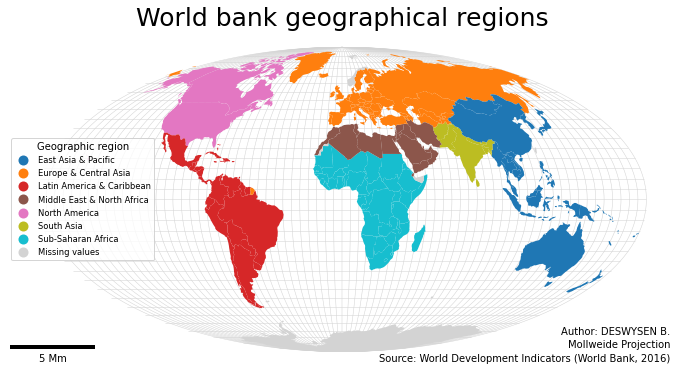

In [38]:
# plot world bank geographical regions
fig, ax = plt.subplots(figsize=(12,10))

ax.axis('off')

gdf_geog_region.plot(column='Region', 
             ax=ax, 
             #cmap='OrRd',categorical=True,
             missing_kwds={'color': 'lightgrey',
                          'label': 'Missing values'},
             legend=True,
             legend_kwds={'loc': 'center left',
                          #'loc': 'lower left',
                          'fontsize':'small',
                          'title':'Geographic region'
                         },
             zorder=2,
             #cax=cax
            )

gdf_graticules_mollweide.plot(
        ax=ax, 
        color="lightgray", 
        linewidth=0.5, 
        zorder=1)

ax.set_title('World bank geographical regions', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})

ax.text(0.99, 0.01, 'Source: World Development Indicators (World Bank, 2016)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.05, 'Mollweide Projection',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.09, 'Author: DESWYSEN B.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

scalebar = ScaleBar(dx=1,units='m',dimension='si-length',location='lower left')

plt.gca().add_artist(scalebar)

plt.savefig('figures/WB_geog_regions.png')

### <span style="color:orange">V.2. Income group classification</span>

The IncomeGroup information is known as a code letter corresponding (for 2006) to a GNI per capita (in $) value:

| Income group	| Group Meaning       	| GNI per capita in US$ (2006) 	|
|------------	|---------------------	|-----------------------	|
| L          	| Low income          	| <= 905                	|
| LM         	| Lower middle income 	| 906-3,595             	|
| UM         	| Upper middle income 	| 3,596-11,115          	|
| H          	| High income         	| > 11,115              	|

In [39]:
# Read  countries classification from world bank xls file.
# We consider only A and V cols and skip rows before 12th line
df_income_group = pd.read_excel(
    r'./data/OGHIST.xls',
    sheet_name='Country Analytical History',
    index_col=None, 
    usecols = "A,V", 
    skiprows= range(1, 11)
)
# drop NaN rows
df_income_group.dropna()

# rebuild the index
df_income_group.reset_index(drop=True)

# Rename cols into countrycode and incomegroup
df_income_group.rename(columns={
    df_income_group.columns[0]:'CountryCode', 
    df_income_group.columns[1]:'IncomeGroup'}, inplace=True)

# Create a new col of the full label of the Income Group for display purpose
df_income_group.loc[df_income_group.IncomeGroup == 'L', 'IncomeGroupLabel'] = '1. Low income'
df_income_group.loc[df_income_group.IncomeGroup == 'LM', 'IncomeGroupLabel'] = '2. Lower middle income'
df_income_group.loc[df_income_group.IncomeGroup == 'UM', 'IncomeGroupLabel'] = '3. Upper middle income'
df_income_group.loc[df_income_group.IncomeGroup == 'H', 'IncomeGroupLabel'] = '4. High income'

print('Dimensions of the dataset: ' )
df_income_group.shape

Dimensions of the dataset: 


(229, 3)

If we want to plot these groups on a map:

In [40]:
# merge countries and income groups dataset using ISO A3 country code
gdf_income_group = gdf_countries_mollweide[['WB_A3', 'geometry']].merge(df_income_group, left_on='WB_A3', right_on='CountryCode', how='left')
gdf_income_group.shape

(177, 5)

In [41]:
gdf_income_group.head()

WB_A3                                           geometry CountryCode  \
0   FJI  MULTIPOLYGON (((17601618.097 -1976619.151, 175...         FJI   
1   TZA  POLYGON ((3397635.186 -117460.561, 3414491.441...         TZA   
2   -99  POLYGON ((-805662.249 3368332.366, -805924.947...         NaN   
3   CAN  MULTIPOLYGON (((-9464830.276 5768352.350, -947...         CAN   
4   USA  MULTIPOLYGON (((-9464830.276 5768352.350, -924...         USA   

  IncomeGroup        IncomeGroupLabel  
0          LM  2. Lower middle income  
1           L           1. Low income  
2         NaN                     NaN  
3           H          4. High income  
4           H          4. High income

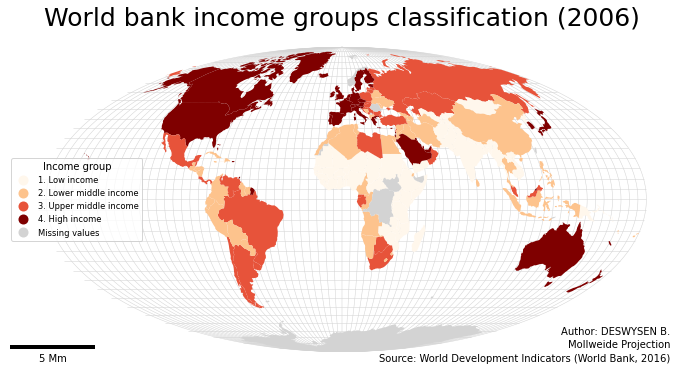

In [54]:
# Plot on a world map
fig, ax = plt.subplots(figsize=(12,10))

ax.axis('off')

gdf_income_group.plot(column='IncomeGroupLabel', 
             ax=ax, 
             cmap='OrRd',categorical=True,
             missing_kwds={'color': 'lightgrey',
                          'label': 'Missing values'},
             legend=True,
             legend_kwds={'loc': 'center left',
                          #'loc': 'lower left',
                          'fontsize':'small',
                          'title':'Income group'
                         },
             zorder=2,
             #cax=cax
            )

gdf_graticules_mollweide.plot(
        ax=ax, 
        color="lightgray", 
        linewidth=0.5, 
        zorder=1)

ax.set_title('World bank income groups classification (2006)', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})

ax.text(0.99, 0.01, 'Source: World Development Indicators (World Bank, 2016)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.05, 'Mollweide Projection',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

ax.text(0.99, 0.09, 'Author: DESWYSEN B.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

scalebar = ScaleBar(dx=1,units='m',dimension='si-length',location='lower left')

plt.gca().add_artist(scalebar)

plt.savefig('figures/World_bank_income_groups_classif_2006.png')

---------------
## <span style="color:red">__VI. Multi-indicator analysis__</span>
---------------



### <span style="color:orange">VI.1. Urban population VS GDP per capita (full dataset)</span>

In [43]:
# create a dataset containg both indices:
index_list=[indicator_gdp,indicator_urb]
year=xmax_gdp

filter1=df_indicators.IndicatorCode.isin(index_list)
filter2=df_indicators.Year==year

df_urban_gdp=df_indicators[filter1 & filter2]

print('Dimensions of the dataset: ' )
df_urban_gdp.shape

Dimensions of the dataset: 


(478, 6)

In [44]:
# merge both dataframes in a same one using the country as key for the join
df_urban_gdp = df_gdp_per_cap_ref_year_norm[['CountryName','CountryCode','Value' ]].merge(
    df_urb_pop_ref_year[['Value', 'CountryName']], 
    left_on='CountryName', 
    right_on='CountryName', 
    how='left')

# Rename indicator cols
df_urban_gdp.rename(columns = {'Value_x':'GDP per capita (current US$)'}, inplace = True) 
df_urban_gdp.rename(columns = {'Value_y':'Urban population (% of total)'}, inplace = True) 

df_urban_gdp.shape

(200, 4)

We can now plot it as Scatter Plot and look at correlation between these 2 indexes in the full dataset:

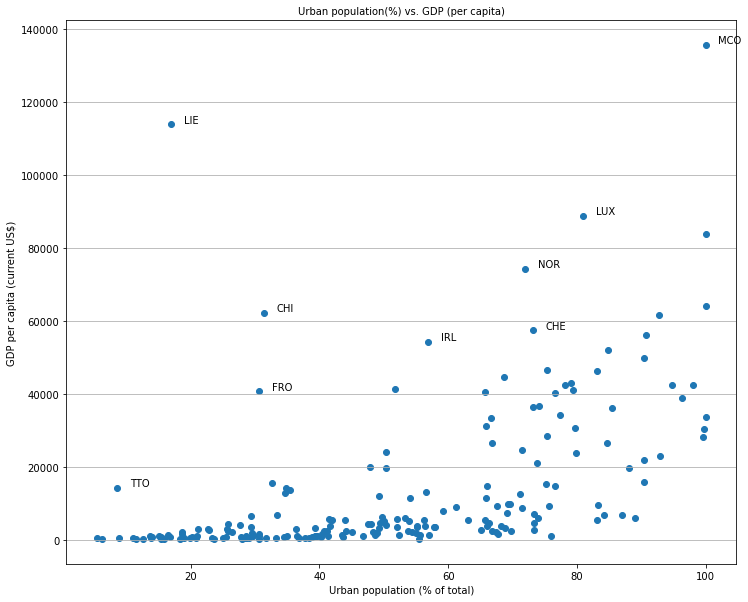

Correlation - PEARSON: 0.5264
Correlation - KENDALL: 0.5571
Correlation - SPEARMAN: 0.7378


In [45]:
# Scatter plot
fig, axis = plt.subplots(figsize=(12,10))

axis.yaxis.grid(True)
axis.set_title('Urban population(%) vs. GDP (per capita)',fontsize=10)
axis.set_xlabel('Urban population (% of total)',fontsize=10)
axis.set_ylabel('GDP per capita (current US$)',fontsize=10)

X = df_urban_gdp['Urban population (% of total)']
Y = df_urban_gdp['GDP per capita (current US$)']

axis.scatter(X, Y)

countries_to_annotate=('CHI','LIE','MCO','LUX','IRL','FRO','NOR','CHE','TTO')
enum_countries = enumerate(countries_to_annotate)
for i, txt in enum_countries:
    country=df_urban_gdp[df_urban_gdp['CountryCode']==txt]
    x=country['Urban population (% of total)'].values[0]
    y=country['GDP per capita (current US$)'].values[0]
    # axis.annotate(txt, (merged_gdb_urb_df['Urban population (% of total)'].iat[i], merged_gdb_urb_df['GDP per capita (current US$)'].iat[i]))
    axis.annotate(txt,
            xy=(x, y), xycoords='data',
            xytext=(x+2, y+500), textcoords='data',
                  #arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )

plt.show()

# Correlation coefficient
pearson=df_urban_gdp.corr(method='pearson').values[0,1]
kendall=df_urban_gdp.corr(method='kendall').values[0,1]
spearman=df_urban_gdp.corr(method='spearman').values[0,1]

print('Correlation - PEARSON: ' + str(round(pearson,4)))
print('Correlation - KENDALL: ' + str(round(kendall,4)))
print('Correlation - SPEARMAN: ' + str(round(spearman,4)))


We can directly observ that some countries have higher GDP per capita compared to other countries with the same proportion of urban population. 2 Countries have very caracteristic behaviour:
- Monaco (MCO) : city-state (100% of urban population) with very high GDP per capita.
- Lichtenstein (LIE): microstate with very high GDP per capita  but low urbanization percentage.

These data tend to disturb the correlation coefficients because they are very far from the values of other countries. We cannot eliminate them and consider as outliers.

__We can see that GDP per capita and urban population (% of total) are highly correlated.__

However, we need to be careful: we cannot establish a direct cause and effect link. 
These two indicators are likely to depend on underlying factors of economic production.

A more detailed approach was considered by evaluating 2 possibilities of aggregating these data into groups:
- Geograhic regions classification
- Income group

Following this secund approuch, we are modifying the granularity of the data and changing the scale of analysis.

### <span style="color:orange">VI.1. Urban population VS GDP per capita in different income goups</span>

In [46]:
# Join with the income group classification file containing regions
df_urban_gdp_aggr_1 =df_urban_gdp.merge(
    df_income_group[['CountryCode','IncomeGroup']],
    left_on='CountryCode',
    right_on='CountryCode',
    how='inner'
)

# Create a new col of the full label of the Income Group for display purpose
df_urban_gdp_aggr_1.loc[df_urban_gdp_aggr_1.IncomeGroup == 'L', 'IncomeGroupLabel'] = '1. Low income'
df_urban_gdp_aggr_1.loc[df_urban_gdp_aggr_1.IncomeGroup == 'LM', 'IncomeGroupLabel'] = '2. Lower middle income'
df_urban_gdp_aggr_1.loc[df_urban_gdp_aggr_1.IncomeGroup == 'UM', 'IncomeGroupLabel'] = '3. Upper middle income'
df_urban_gdp_aggr_1.loc[df_urban_gdp_aggr_1.IncomeGroup == 'H', 'IncomeGroupLabel'] = '4. High income'

# Join with the country.csv file containing regions
df_urban_gdp_aggr =df_urban_gdp_aggr_1.merge(
    df_countries_wb_classif[['CountryCode','Region']],
    left_on='CountryCode',
    right_on='CountryCode',
    how='inner'
)

print('Dimensions of the dataset: ' )
df_urban_gdp_aggr.shape

Dimensions of the dataset: 


(193, 7)

In [47]:
df_urban_gdp_aggr.head()

CountryName CountryCode  GDP per capita (current US$)  \
0   Afghanistan         AFG                    280.245644   
1       Algeria         DZA                   3467.544740   
2     Australia         AUS                  36084.858978   
3       Austria         AUT                  40430.993614   
4  Bahamas, The         BHS                  23721.156280   

   Urban population (% of total) IncomeGroup        IncomeGroupLabel  \
0                         18.316           L           1. Low income   
1                         52.085          LM  2. Lower middle income   
2                         85.400           H          4. High income   
3                         65.765           H          4. High income   
4                         79.838           H          4. High income   

                       Region  
0                  South Asia  
1  Middle East & North Africa  
2         East Asia & Pacific  
3       Europe & Central Asia  
4   Latin America & Caribbean

Text(0.0, 1.0, 'Urban population(%) vs. GDP (per capita)')

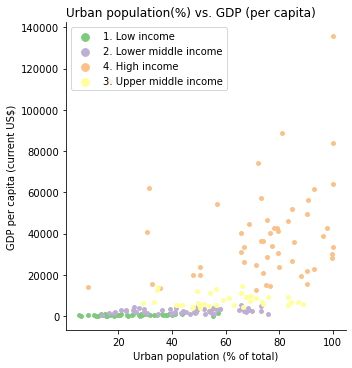

In [48]:
# Plot per income group
sns.lmplot( x='Urban population (% of total)', 
           y='GDP per capita (current US$)', 
           data=df_urban_gdp_aggr, 
           fit_reg=False, 
           hue='IncomeGroupLabel', 
           legend=False, 
           palette="Accent", 
           scatter_kws={"alpha":1,"s":15} )
 
# Legend
plt.legend(loc='upper left', markerscale=2)
 
# titles
plt.xlabel('Urban population (% of total)')
plt.ylabel('GDP per capita (current US$)')
plt.title('Urban population(%) vs. GDP (per capita)', loc='left')



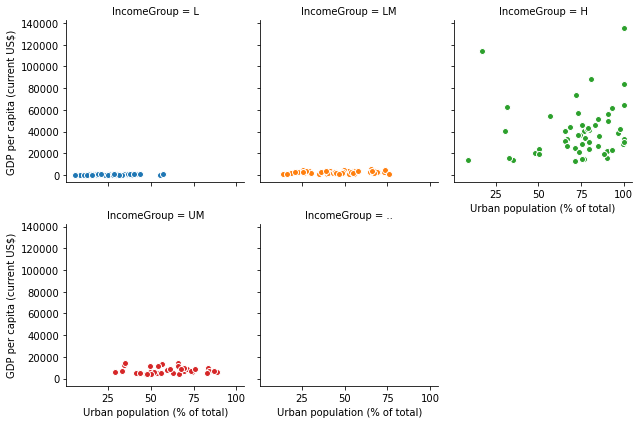

In [49]:


g = sns.FacetGrid(
    data=df_urban_gdp_aggr, 
    col="IncomeGroup", 
    hue="IncomeGroupLabel",
    col_wrap=3)
g = (g.map(
    plt.scatter, 
    'Urban population (% of total)', 
    'GDP per capita (current US$)', 
    edgecolor="w"))

### <span style="color:orange">VI.2. Urban population VS GDP per capita in different geographic regions</span>

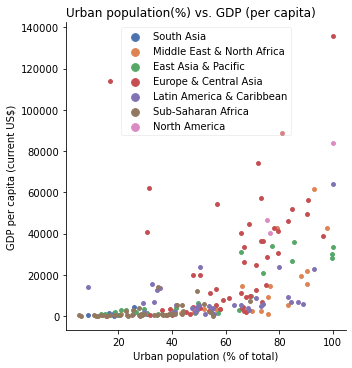

In [50]:
sns.reset_orig()

# Plot per region
sns.lmplot( x='Urban population (% of total)', 
           y='GDP per capita (current US$)', 
           data=df_urban_gdp_aggr, 
           fit_reg=False, 
           hue='Region', 
           legend=False, 
           palette="deep", 
           scatter_kws={"alpha":1,"s":15} )



# Legend
plt.legend(loc='upper center', markerscale=2, framealpha=0.3)
 
# titles
plt.xlabel('Urban population (% of total)')
plt.ylabel('GDP per capita (current US$)')
plt.title('Urban population(%) vs. GDP (per capita)', loc='left')

plt.savefig('figures/Urban_pop_vs_GDP_per_cap.png')

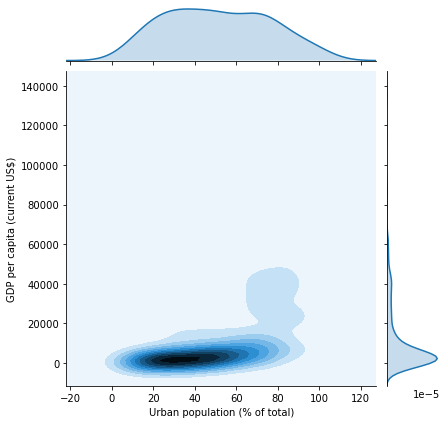

In [55]:
# 2D density + marginal distribution:
sns.jointplot( x='Urban population (% of total)', 
              y='GDP per capita (current US$)', 
              data=df_urban_gdp_aggr, 
              kind='kde')
plt.savefig('figures/Urban_pop_vs_GDP_per_cap_KDE.png')

In [52]:
df_urban_gdp_aggr

CountryName CountryCode  GDP per capita (current US$)  \
0              Afghanistan         AFG                    280.245644   
1                  Algeria         DZA                   3467.544740   
2                Australia         AUS                  36084.858978   
3                  Austria         AUT                  40430.993614   
4             Bahamas, The         BHS                  23721.156280   
..                     ...         ...                           ...   
188        Channel Islands         CHI                  62260.225545   
189         Faeroe Islands         FRO                  40617.304977   
190             San Marino         SMR                  49682.093659   
191             Montenegro         MNE                   4383.595097   
192  Sao Tome and Principe         STP                    858.587831   

     Urban population (% of total) IncomeGroup        IncomeGroupLabel  \
0                           18.316           L           1. Low income   
1                           52.085          LM  2. Lower middle income   
2                           85.400           H          4. High income   
3                           65.765           H          4. High income   
4                           79.838           H          4. High income   
..                             ...         ...                     ...   
188                         31.392           H          4. High income   
189                         30.594           H          4. High income   
190                         90.400           H          4. High income   
191                         48.037          UM  3. Upper middle income   
192                         43.648           L           1. Low income   

                         Region  
0                    South Asia  
1    Middle East & North Africa  
2           East Asia & Pacific  
3         Europe & Central Asia  
4     Latin America & Caribbean  
..                          ...  
188       Europe & Central Asia  
189       Europe & Central Asia  
190       Europe & Central Asia  
191       Europe & Central Asia  
192          Sub-Saharan Africa  

[193 rows x 7 columns]

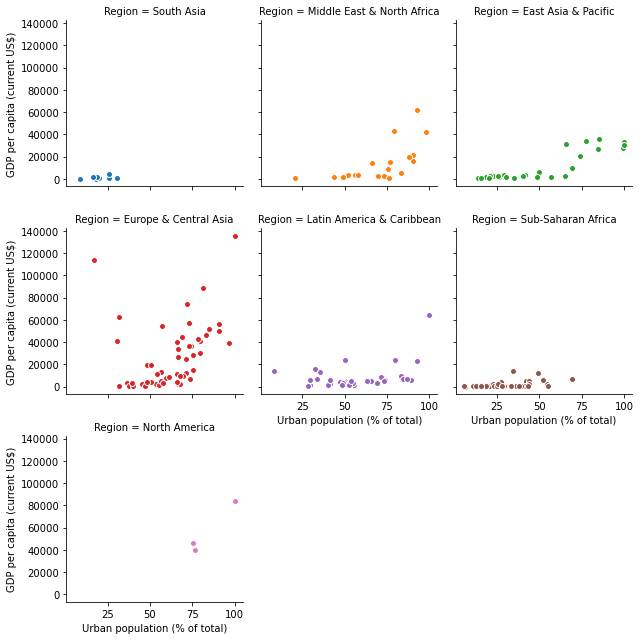

In [62]:
# reset Seaborn display param to default
sns.reset_orig()

# plot per Region
g = sns.FacetGrid(
    data=df_urban_gdp_aggr, 
    col="Region", 
    hue="Region",
    col_wrap=3)
g = (g.map(
    plt.scatter, 
    'Urban population (% of total)', 
    'GDP per capita (current US$)', 
    edgecolor="w"))

plt.savefig('figures/Urban_pop_vs_GDP_per_cap_grouped_by_region.png')

In [58]:
# compute correlations per Region
regions = df_urban_gdp_aggr['Region'].unique()
regions

# Print correlation coefficients
print ('PEARSON:')
for r in regions:
    corr_mat = df_urban_gdp_aggr[df_urban_gdp_aggr['Region']==r].corr(method='pearson')
    corr_val = corr_mat['GDP per capita (current US$)'].iloc[1]
    print('    '+r+': '+str(round(corr_val,4)))
    
print ('KENDALL:')
for r in regions:
    corr_mat = df_urban_gdp_aggr[df_urban_gdp_aggr['Region']==r].corr(method='kendall')
    corr_val = corr_mat['GDP per capita (current US$)'].iloc[1]
    print('    '+r+': '+str(round(corr_val,4)))
    
print ('SPEARMAN:')
for r in regions:
    corr_mat = df_urban_gdp_aggr[df_urban_gdp_aggr['Region']==r].corr(method='spearman')
    corr_val = corr_mat['GDP per capita (current US$)'].iloc[1]
    print('    '+r+': '+str(round(corr_val,4)))

PEARSON:
    South Asia: 0.3676
    Middle East & North Africa: 0.6439
    East Asia & Pacific: 0.8644
    Europe & Central Asia: 0.3215
    Latin America & Caribbean: 0.3652
    Sub-Saharan Africa: 0.452
    North America: 0.9843
KENDALL:
    South Asia: 0.3571
    Middle East & North Africa: 0.6526
    East Asia & Pacific: 0.6402
    Europe & Central Asia: 0.4311
    Latin America & Caribbean: 0.2
    Sub-Saharan Africa: 0.4626
    North America: 0.3333
SPEARMAN:
    South Asia: 0.4286
    Middle East & North Africa: 0.8211
    East Asia & Pacific: 0.8336
    Europe & Central Asia: 0.5343
    Latin America & Caribbean: 0.2494
    Sub-Saharan Africa: 0.6005
    North America: 0.5
